## Imports

In [1]:
import io
import glob
import os, os.path
import tarfile
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
import joblib
from matplotlib_venn import venn3, venn3_circles

warnings.filterwarnings('ignore')

In [2]:
colors=['#264b96','#bf212f','#006f3c']
sns.set_theme(style='whitegrid')
sns.set_palette(sns.color_palette(colors))

## Function definitions

In [6]:
def read_result(df_pairs, dir_path, model, metric, init_batch, explor_batch, seed):
    df_result = pd.DataFrame()
    archive_name = f'{dir_path}output_{model}_{metric}_{init_batch}_{explor_batch}_{seed}.tar.gz'
    with tarfile.open(archive_name, 'r:gz') as tar:
        for i in range(len(tar.getmembers())-3):
            extracted_file = tar.extractfile(f'{i}_batch_idxs.npy') 
            batch_idxs = np.load(io.BytesIO(extracted_file.read()))

            df_ = df_pairs.iloc[batch_idxs].copy()
            df_['batch'] = i
            df_['model'] = model
            df_['metric'] = metric
            df_['init_batch'] = init_batch
            df_['batch_size'] = explor_batch
            df_['seed'] = seed
            
            df_result = pd.concat([df_result, df_])
    return df_result

In [7]:
def read_results(df_pairs, dir_path):
    df_results = pd.DataFrame()
    for seed in [1, 2, 3]:
        for model in ['logreg','rf','mlp']:
            for metric in ['greedy', 'tompson', 'sd_deviation']:
                for init_batch in [0.001, 0.0025, 0.005, 0.01, 0.025]:
                    explor_batch = 0.005
                    df_results = pd.concat([df_results, 
                                            read_result(df_pairs, dir_path, model, metric, init_batch, explor_batch, seed)
                                           ])
                for explor_batch in [0.0025, 0.01, 0.025]:
                    init_batch = 0.005
                    df_results = pd.concat([df_results, 
                                            read_result(df_pairs, dir_path, model, metric, init_batch, explor_batch, seed)
                                           ])
    return df_results

In [8]:
def read_time(dir_path, model, metric, init_batch, batch_size, seed):
    archive_name = f'{dir_path}output_{model}_{metric}_{init_batch}_{batch_size}_{seed}.tar.gz'
    with tarfile.open(archive_name, 'r:gz') as tar:
        extracted_file = tar.extractfile(f'training_time.npy')
        training_time = np.load(io.BytesIO(extracted_file.read()))
        extracted_file = tar.extractfile(f'predicting_time.npy')
        predicting_time = np.load(io.BytesIO(extracted_file.read()))
        extracted_file = tar.extractfile(f'acquisition_time.npy')
        acquisition_time = np.load(io.BytesIO(extracted_file.read()))

        df_time = pd.DataFrame([[model, metric, init_batch, batch_size, training_time.sum(), predicting_time.sum(), acquisition_time.sum(), seed]], 
                           columns=['model','metric','init_batch','batch_size','training_time','predicting_time', 'acquisition_time', 'seed'])

    return df_time

In [9]:
def read_times(dir_path):
    df_times = pd.DataFrame()
    for seed in [1, 2, 3]:
        for model in ['logreg','rf','mlp']:
            for metric in ['greedy', 'tompson', 'sd_deviation']:
                for init_batch in [0.001, 0.0025, 0.005, 0.01, 0.025]:
                    batch_size = 0.005
                    df_times = pd.concat([df_times, 
                                          read_time(dir_path, model, metric, init_batch, batch_size, seed)
                                         ])
                
                for batch_size in [0.0025, 0.01, 0.025]:
                    init_batch = 0.005
                    df_times = pd.concat([df_times, 
                                          read_time(dir_path, model, metric, init_batch, batch_size, seed)
                                         ])
    df_times = df_times.groupby(by=['model','metric','init_batch','batch_size']).mean()
    df_times.reset_index(inplace=True)
    return df_times

In [10]:
def count(df_pairs, df, q, q_polar):
    df['hit'] = (df['IFP'] >= q) & (df['IFP_polar']>=q_polar)
    total_records = len(df_pairs)
    total_hits = len(df_pairs[(df_pairs['IFP'] >= q) & (df_pairs['IFP_polar'] >= q_polar)])
    df_counters = df.groupby([
        'init_batch','batch_size','model','metric', 'seed', 'batch'
        ])['hit'].aggregate(['sum','count']).rename(columns={'sum': 'hits', 'count': 'size'})
    df_counters = df_counters.groupby(by=['init_batch','batch_size','model','metric','batch']).mean()
    
    df_counters['accumulated_size'] = df_counters.groupby(level=['init_batch','batch_size','model','metric'])['size'].cumsum()
    df_counters['accumulated_hits'] = df_counters.groupby(level=['init_batch','batch_size','model','metric'])['hits'].cumsum()
    
    df_counters['percent_explored'] = 100*df_counters['accumulated_size']/total_records
    df_counters['percent_hits'] = 100*df_counters['accumulated_hits']/total_hits
    return df_counters

In [11]:
def get_value(group, p):
    if p in group['percent_explored'].values:
        return round(float(group.loc[group['percent_explored'] == p, 'percent_hits']), 3)
    elif p < group['percent_explored'].values.min():
        return 0
    else:
        f = interp1d(group['percent_explored'], group['percent_hits'], kind='linear')
        return np.round(f(p), decimals=3)

In [12]:
def get_handles(df_pairs, df_results, q, q_polar):
    data = count(df_pairs, df_results, q, q_polar).reset_index()
    plot = sns.relplot(
        data=data[data['batch_size'] == 0.005],
        x='percent_explored', 
        y='percent_hits', 
        col='init_batch', 
        hue='model', 
        style='metric', 
        kind='line',
        markers=False,
        legend=True,
        height=6,
        aspect=0.7
    )
    plot.axes[0,0].plot([0,10],[0,10], color='grey', label='random')
    handles, labels = plot.axes[0,0].get_legend_handles_labels()
    plt.close()
    return handles

In [13]:
def plot_init_batches(df_pairs, df_results, q, q_polar):
    data = count(df_pairs, df_results, q, q_polar).reset_index()
    group='init_batch'
    fix = 'batch_size'
    plot = sns.relplot(
        data=data[data[fix] == 0.005],
        x='percent_explored', 
        y='percent_hits', 
        col=group, 
        hue='model', 
        style='metric', 
        kind='line',
        markers=False,
        legend=False,
        height=6,
        aspect=0.7
    )
    sizes = ['0.10%', '0.25%', '0.50%', '1.00%', '2.50%']
    sides = ['top', 'bottom', 'right', 'left']
    for i, ax in enumerate(plot.axes.flat):
        ax.plot([0,10],[0,10], color='grey', label='random')
        ax.tick_params(axis='both', which='both', labelsize=17)
        ax.grid(linewidth=2)
        
        #title = ax.set_title(f'{sizes[i]}', fontsize=20)
        title = ax.set_title(f'{sizes[i]}', fontsize=20, position=(.5, 1.05),
             backgroundcolor='white', color='black',
             verticalalignment="bottom", horizontalalignment="center", bbox=dict(edgecolor='black', linewidth=1.5, facecolor='whitesmoke'))
        title._bbox_patch._mutation_aspect = 0.058
        title.get_bbox_patch().set_boxstyle("square", pad=4.88)
        
        for side in sides:
            ax.spines[side].set_visible(True)
            ax.spines[side].set_linestyle('-')
            ax.spines[side].set_color('black')
    plot.set_ylabels("Percentage of hits found", fontsize=24)
    plot.set_xlabels("Percentage of pairs explored", fontsize=20)
    plt.xlim([0, 10])
    plt.ylim([0, 100])
    plt.subplots_adjust(wspace=0.15)
    labels = ['Model', 'LogReg', 'MLP', 'RF', 'Metric', 'Greedy', 'SD', 'Thompson', 'Random']
    #plot.axes[0,4].legend(handles, labels, bbox_to_anchor=(1.03, 1.02), fontsize=16)
    plot.axes[0,2].legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=9, fontsize=20)
    #plt.savefig(f'/projects/ML-SpaceDock/pictures/CACHE4_1M_with_reaction_descriptors_init_batch_ifp_{q}_polar_0.25.png', dpi=300, bbox_inches='tight')

In [14]:
def plot_explor_batches(df_pairs, df_results, q, q_polar):
    data = count(df_pairs, df_results, q, q_polar).reset_index()
    group='batch_size'
    fix = 'init_batch'
    plot = sns.relplot(
        data=data[data[fix] == 0.005],
        x='percent_explored', 
        y='percent_hits', 
        col=group, 
        hue='model', 
        style='metric', 
        kind='line',
        markers=False,
        legend=False,
        height=6,
        aspect=0.7
    )
    sizes = ['0.25%', '0.50%', '1.00%', '2.50%']
    sides = ['top', 'bottom', 'right', 'left']
    for i, ax in enumerate(plot.axes.flat):
        ax.plot([0,10],[0,10], color='grey', label='random')
        ax.tick_params(axis='both', which='both', labelsize=17)
        ax.grid(linewidth=2)
        
        #title = ax.set_title(f'{sizes[i]}', fontsize=20)
        title = ax.set_title(f'{sizes[i]}', fontsize=20, position=(.5, 1.05),
             backgroundcolor='white', color='black',
             verticalalignment="bottom", horizontalalignment="center", bbox=dict(edgecolor='black', linewidth=1.5, facecolor='whitesmoke'))
        title._bbox_patch._mutation_aspect = 0.058
        title.get_bbox_patch().set_boxstyle("square", pad=5.07)
        
        for side in sides:
            ax.spines[side].set_visible(True)
            ax.spines[side].set_linestyle('-')
            ax.spines[side].set_color('black')
    plot.set_ylabels("Percentage of hits found", fontsize=24)
    plot.set_xlabels("Percentage of pairs explored", fontsize=20)
    plt.xlim([0, 10])
    plt.ylim([0, 100])
    plt.subplots_adjust(wspace=0.1)
    labels = ['Model', 'LogReg', 'MLP', 'RF', 'Metric', 'Greedy', 'SD', 'Thompson', 'Random']
    #plot.axes[0,4].legend(handles, labels, bbox_to_anchor=(1.03, 1.02), fontsize=16)
    plot.axes[0,2].legend(handles, labels, loc='upper center', bbox_to_anchor=(-0.17, 1.25), ncol=9, fontsize=18)
    #plt.savefig(f'/projects/ML-SpaceDock/pictures/CACHE4_1M_with_reaction_descriptors_batch_size_ifp_{q}_polar_0.25.png', dpi=300, bbox_inches='tight')

In [12]:
def plot_venn(df_pairs, df_greedy, df_tompson, df_sd, q, q_polar):
    total_hits = len(df_pairs[(df_pairs['IFP'] >= q) & (df_pairs['IFP_polar'] >= q_polar)])
    
    set1 = set(zip(df_greedy['name_1'], df_greedy['name_2'], df_greedy['reaction']))
    set2 = set(zip(df_tompson['name_1'], df_tompson['name_2'], df_tompson['reaction']))
    set3 = set(zip(df_sd['name_1'], df_sd['name_2'], df_sd['reaction']))

    v = venn3(subsets=(1, 1, 1, 1, 1, 1, 1), set_labels = ('Greedy', 'Thompson', 'SD'))
    v.get_patch_by_id('100').set_alpha(0.6)
    v.get_patch_by_id('100').set_color('#FFA7B4')
    c = venn3_circles(subsets=(1, 1, 1, 1, 1, 1, 1), linestyle='dashed', linewidth=0.8, color="black")
    
    only1 = len(set1 - set2 - set3)
    only2 = len(set2 - set1 - set3)
    only3 = len(set3 - set1 - set2)
    only12 = len(set1 & set2 - set3)
    only13 = len(set1 & set3 - set2)
    only23 = len(set2 & set3 - set1)
    all3 = len(set1 & set2 & set3)
    
    v.get_label_by_id('100').set_text(only1)
    v.get_label_by_id('010').set_text(only2)
    v.get_label_by_id('001').set_text(only3)
    v.get_label_by_id('110').set_text(only12)
    v.get_label_by_id('101').set_text(only13)
    v.get_label_by_id('011').set_text(only23)
    v.get_label_by_id('111').set_text(all3)
    
    v.get_label_by_id('A').set_text(f'Greedy, {len(set1)} ({round(100*len(df_greedy)/total_hits, 2)}%)')
    v.get_label_by_id('B').set_text(f'Thompson, {len(set2)} ({round(100*len(df_tompson)/total_hits, 2)}%)')
    v.get_label_by_id('C').set_text(f'SD, {len(set3)} ({round(100*len(df_sd)/total_hits, 2)}%)')

    plt.title("Number of hits retrieved", fontsize=16)
    
    #plt.savefig(f'/projects/ML-SpaceDock/pictures/DRD3_logreg_hits_by_metric.png', dpi=300, bbox_inches='tight')
    plt.show()

# Results exploration

### 1M DRD3

In [13]:
df_pairs = pd.read_csv('/projects/ML-SpaceDock/data/DRD3/1M_DRD3_pairs.tsv', delimiter='\t')
df_results = read_results(df_pairs, '/projects/ML-SpaceDock/DRD3_1M/results/')
df_times = read_times('/projects/ML-SpaceDock/DRD3_1M/results/')

In [14]:
q = 0.6
q_polar = 0.5

In [15]:
df_counters = count(df_pairs, df_results[df_results['batch_size'] == 0.005], q, q_polar)
df = pd.DataFrame()
df.index = df_counters.groupby(by=['init_batch','model','metric']).apply(lambda group: get_value(group, 5)).index
for p in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    df[f'{p}%'] = df_counters.groupby(by=['init_batch','model','metric']).apply(lambda group: get_value(group, p))
df.style.highlight_max(color = 'yellow', axis = 0)

In [16]:
df_counters = count(df_pairs, df_results[df_results['init_batch'] == 0.005], q, q_polar)
df = pd.DataFrame()
df.index = df_counters.groupby(by=['batch_size','model','metric']).apply(lambda group: get_value(group, 5)).index
for p in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    df[f'{p}%'] = df_counters.groupby(by=['batch_size','model','metric']).apply(lambda group: get_value(group, p))
df.style.highlight_max(color = 'yellow', axis = 0)

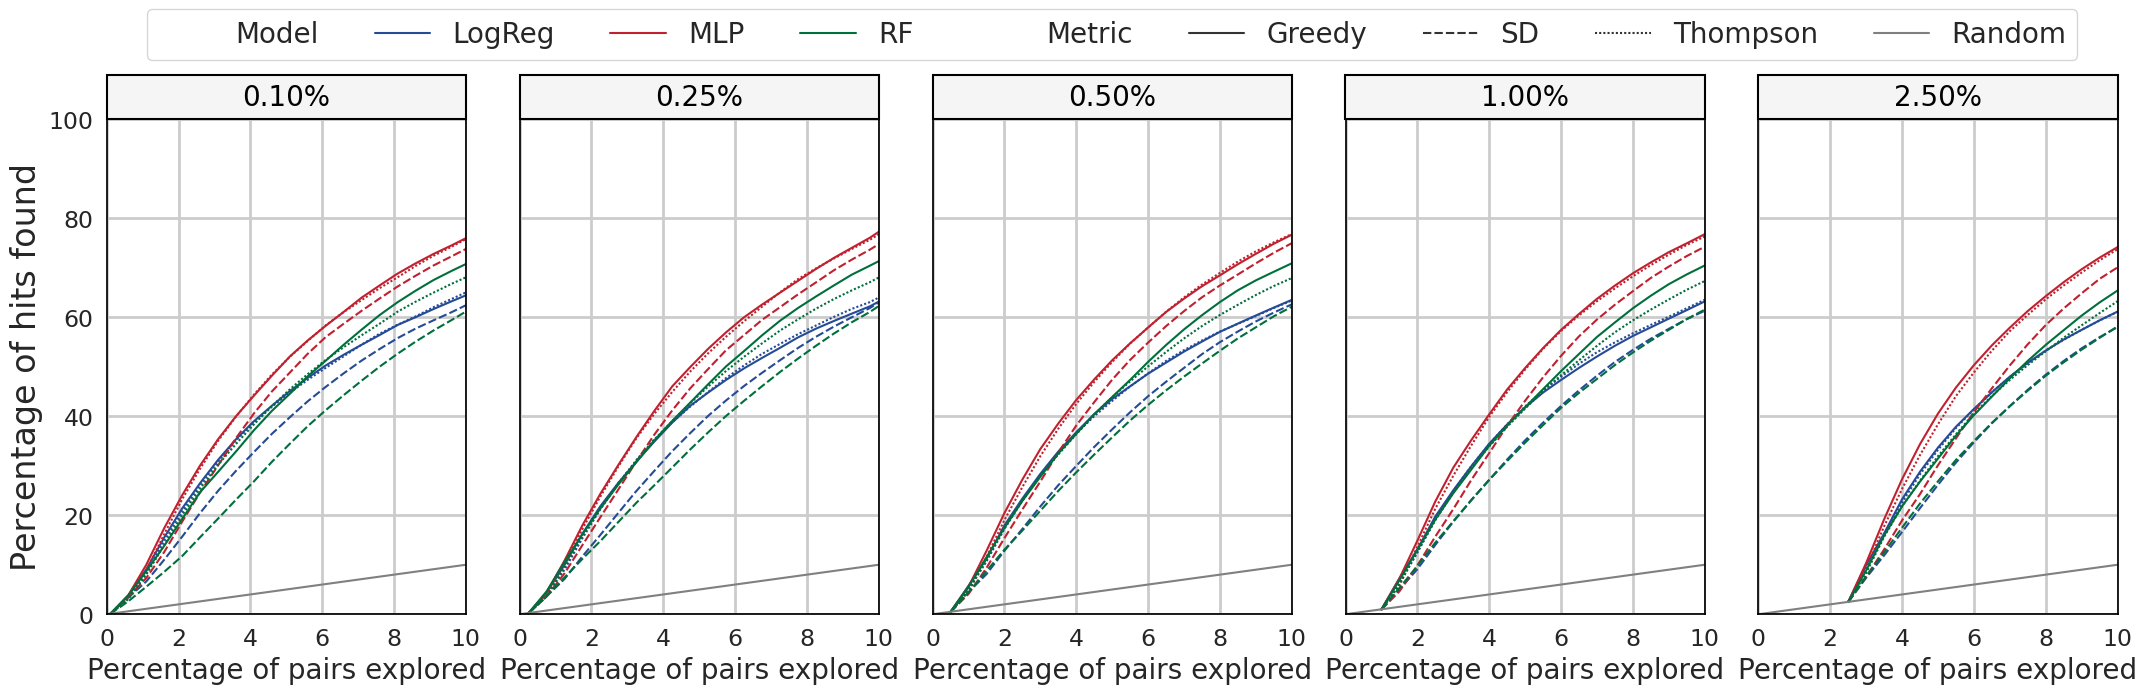

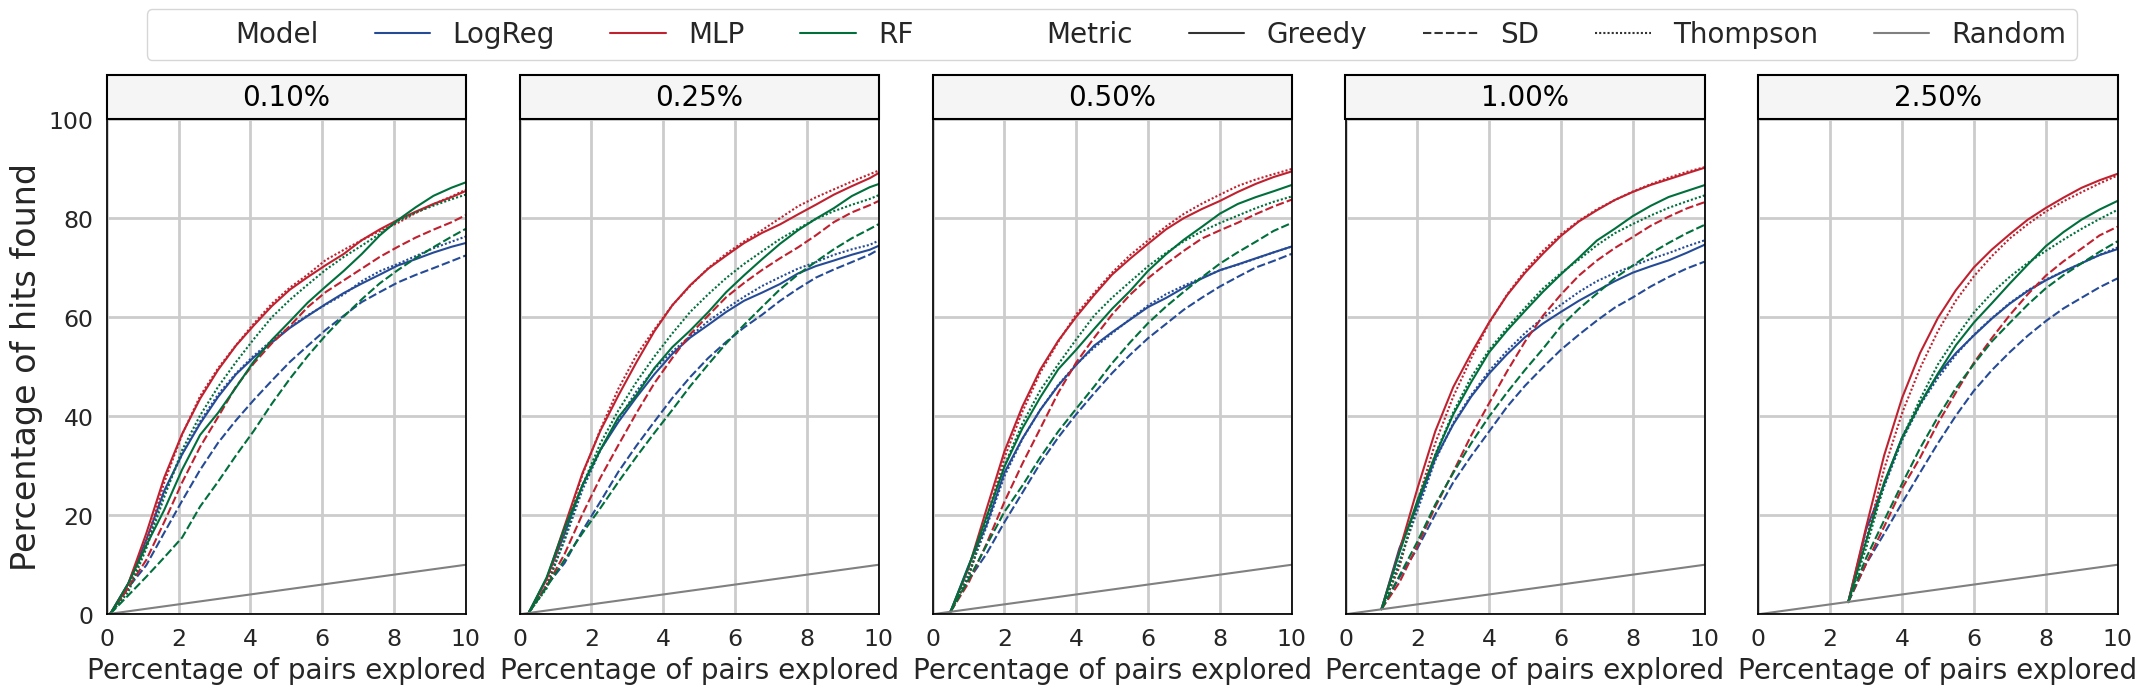

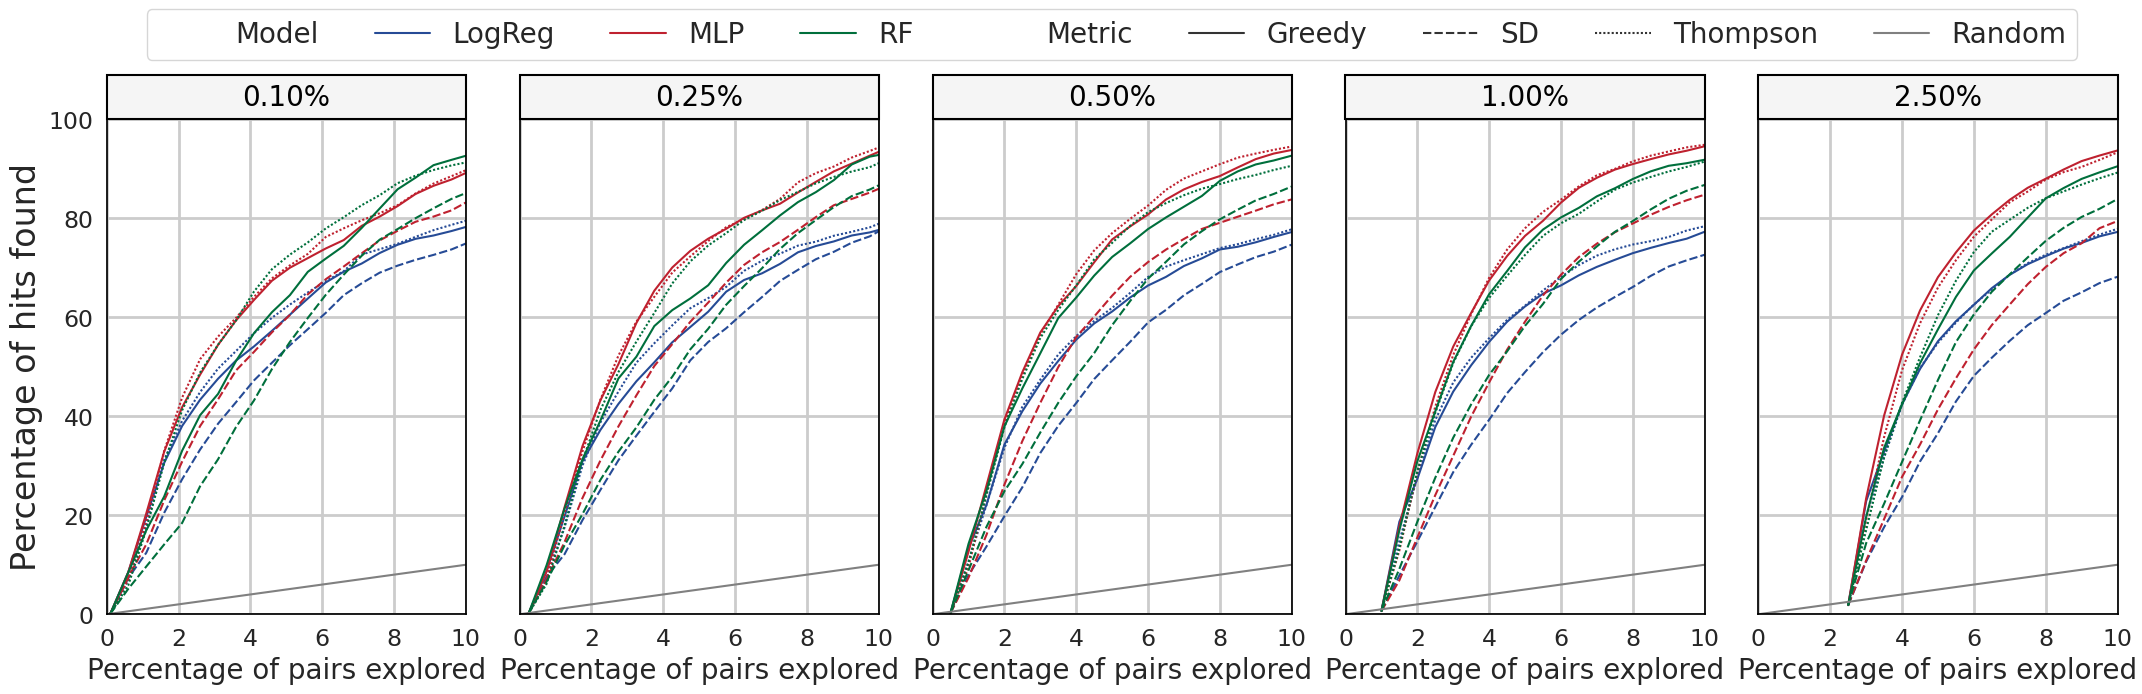

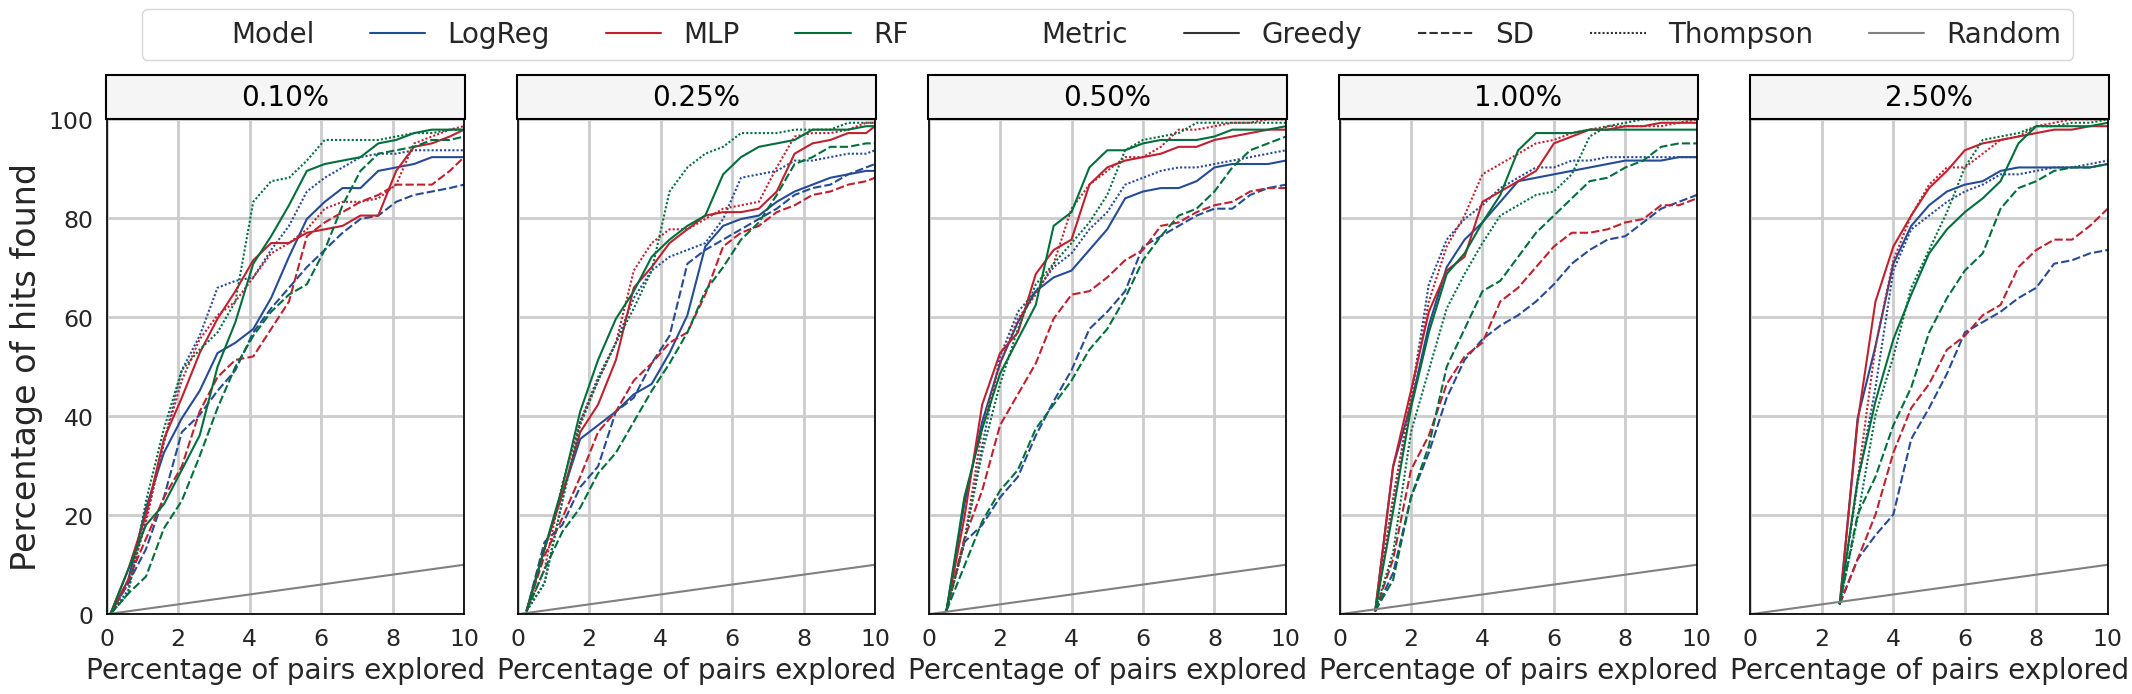

In [17]:
handles = get_handles(df_pairs, df_results, q, q_polar)
for q in [0.6, 0.7, 0.8, 0.9]:
    q_polar =0.5
    plot_init_batches(df_pairs, df_results, q, q_polar)

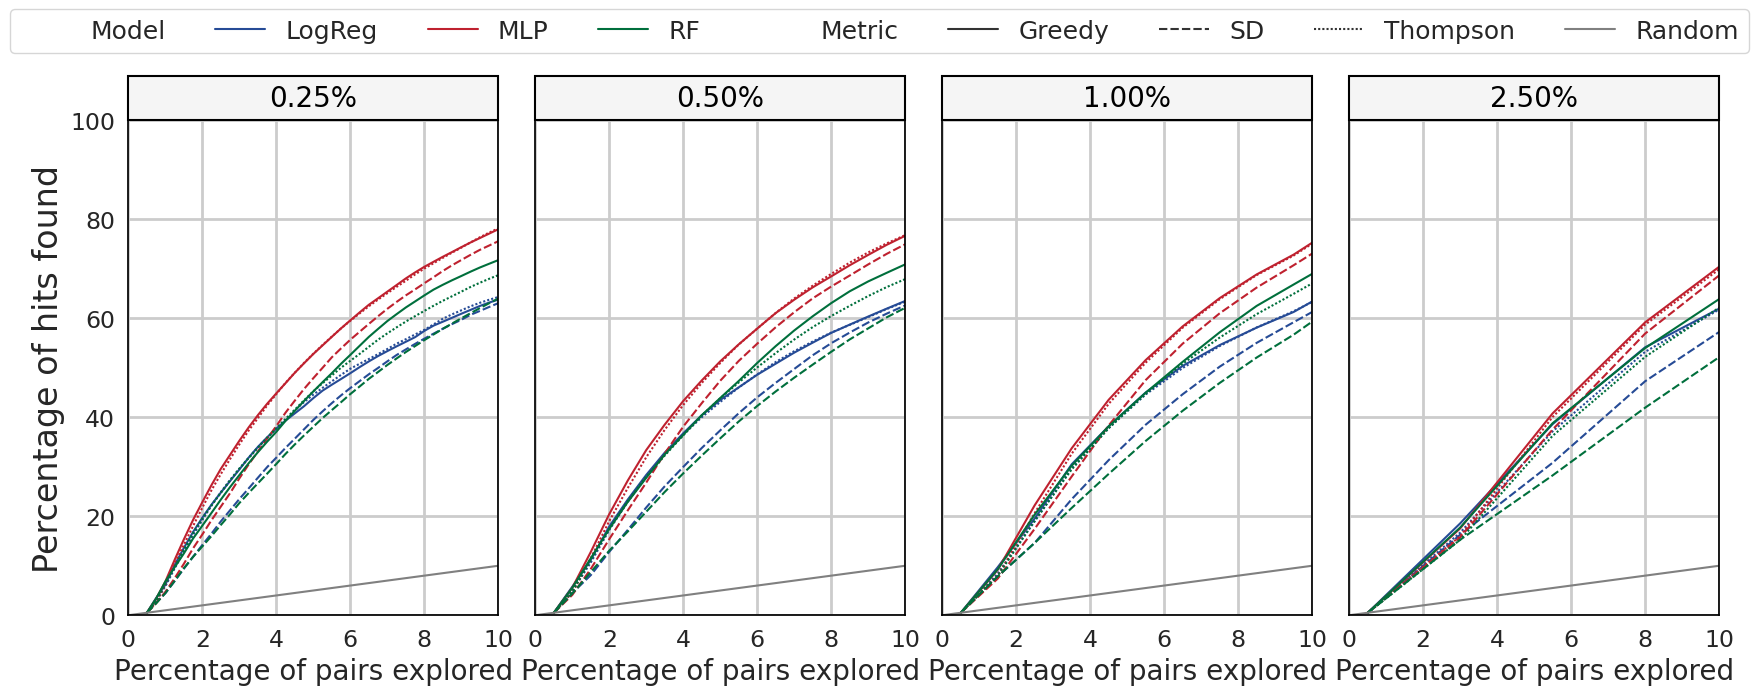

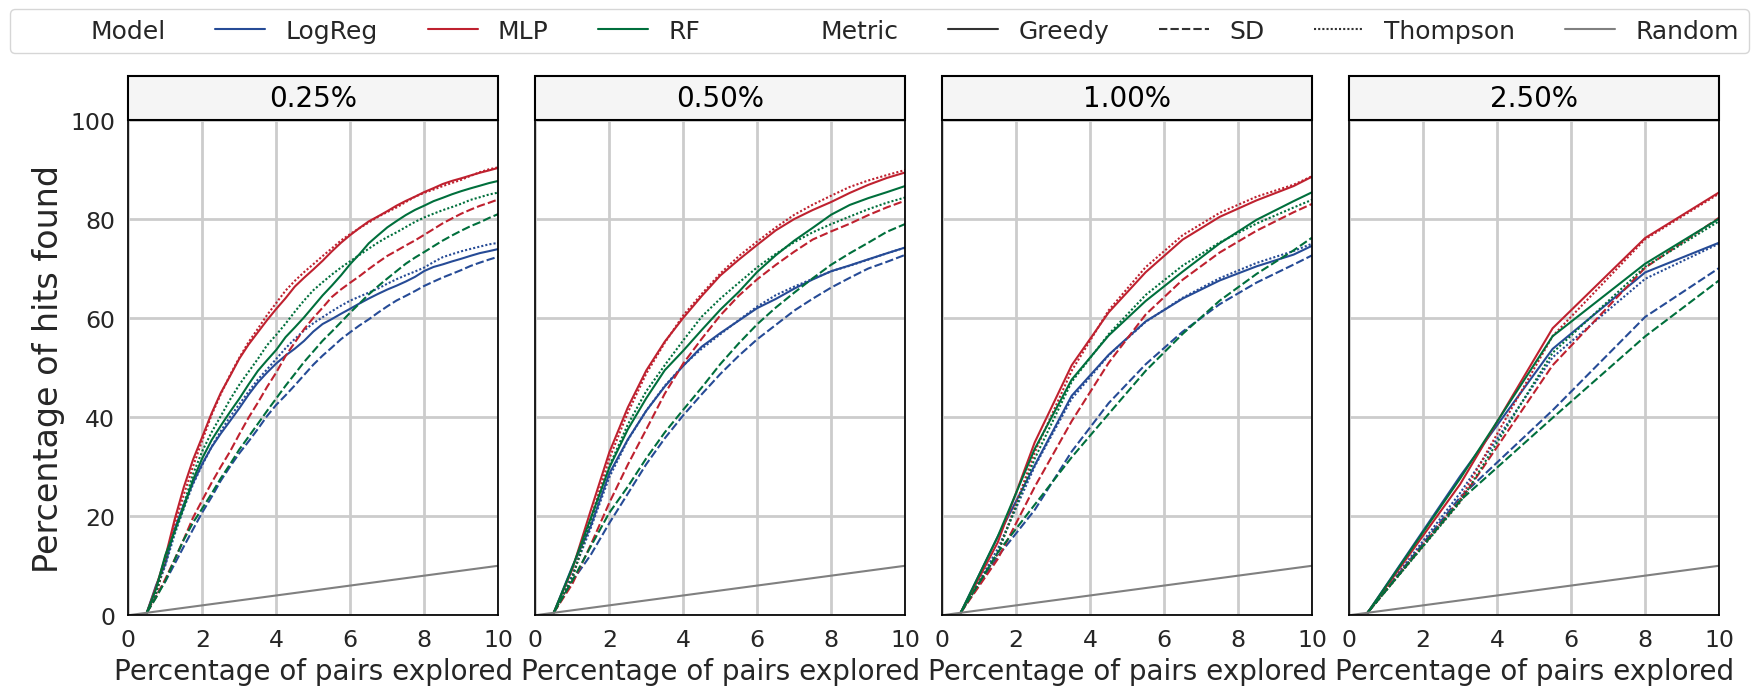

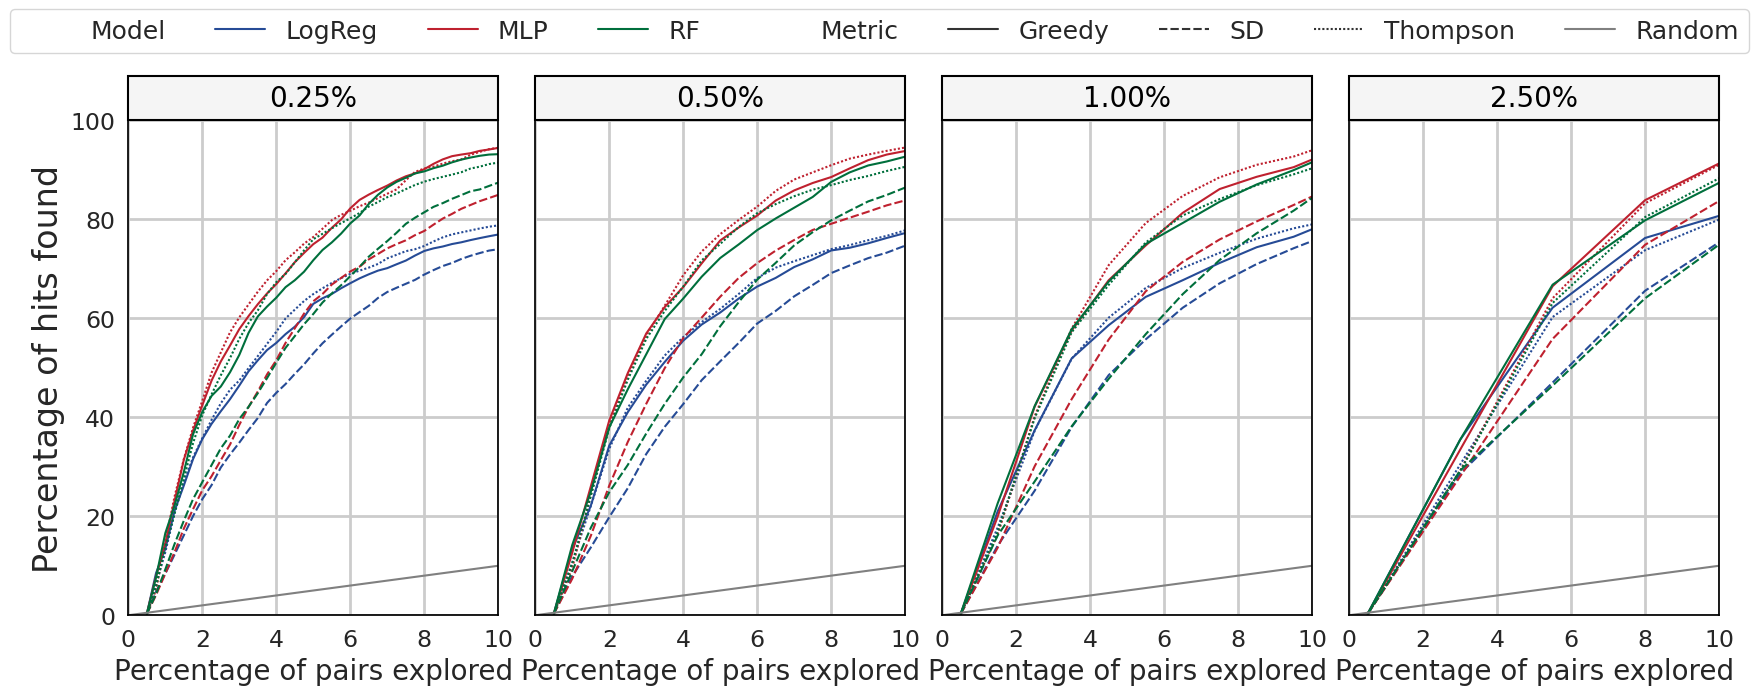

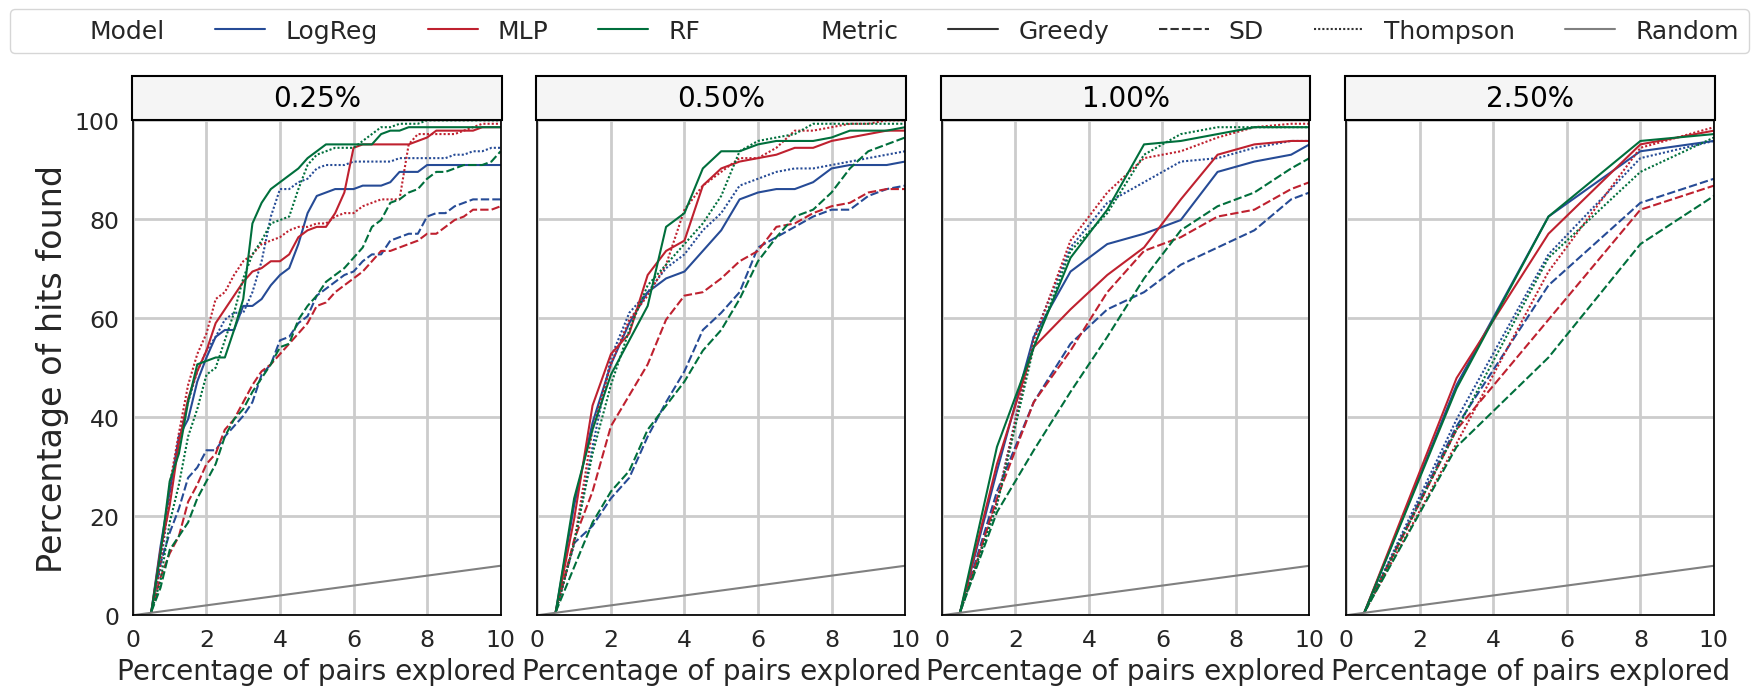

In [18]:
handles = get_handles(df_pairs, df_results, q, q_polar)
for q in [0.6, 0.7, 0.8, 0.9]:
    q_polar =0.5
    plot_explor_batches(df_pairs, df_results, q, q_polar)

In [19]:
q = 0.6
q_polar = 0.5

In [20]:
df_results['reaction'] = 'Amide'
cond_greedy = (df_results['metric']=='greedy')&(df_results['model']=='mlp')&(df_results['init_batch']==0.005)&(df_results['batch_size']==0.005)&(df_results['seed']==1)&(df_results['IFP']>=q)&(df_results['IFP_polar']>=q_polar)
cond_tompson = (df_results['metric']=='tompson')&(df_results['model']=='mlp')&(df_results['init_batch']==0.005)&(df_results['batch_size']==0.005)&(df_results['seed']==1)&(df_results['IFP']>=q)&(df_results['IFP_polar']>=q_polar)
cond_sd = (df_results['metric']=='sd_deviation')&(df_results['model']=='mlp')&(df_results['init_batch']==0.005)&(df_results['batch_size']==0.005)&(df_results['seed']==1)&(df_results['IFP']>=q)&(df_results['IFP_polar']>=q_polar)
df_greedy = df_results[cond_greedy][['name_1','name_2','reaction']]
df_tompson = df_results[cond_tompson][['name_1','name_2','reaction']]
df_sd = df_results[cond_sd][['name_1','name_2','reaction']]

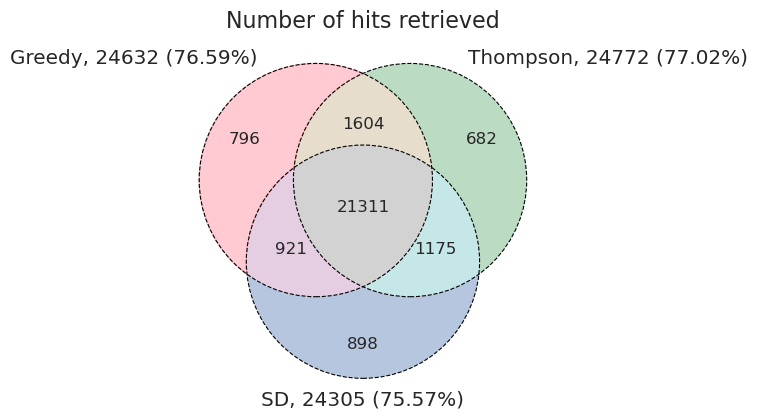

In [21]:
plot_venn(df_pairs, df_greedy, df_tompson, df_sd, q, q_polar)

In [22]:
df_times['overall_time'] = df_times['training_time'] + df_times['predicting_time'] + df_times['acquisition_time'] 
df_times

model   metric  init_batch  batch_size  training_time  predicting_time  \
0   logreg   greedy      0.0010      0.0050      83.787406        15.576809   
1   logreg   greedy      0.0025      0.0050      80.185540        14.583364   
2   logreg   greedy      0.0050      0.0025     163.691563        34.397355   
3   logreg   greedy      0.0050      0.0050      68.666122        15.421370   
4   logreg   greedy      0.0050      0.0100      52.128720        11.487245   
..     ...      ...         ...         ...            ...              ...   
67      rf  tompson      0.0050      0.0050    5283.167295      1048.152759   
68      rf  tompson      0.0050      0.0100    3050.168122       592.163640   
69      rf  tompson      0.0050      0.0250    1124.575738       245.042187   
70      rf  tompson      0.0100      0.0050    5864.781710      1200.048017   
71      rf  tompson      0.0250      0.0050    4179.280546       802.736645   

    acquisition_time  seed  overall_time  
0           2.889508   2.0    102.253723  
1           2.508055   2.0     97.276958  
2           6.016165   2.0    204.105083  
3           2.563209   2.0     86.650701  
4           1.549976   2.0     65.165940  
..               ...   ...           ...  
67          3.126931   2.0   6334.446985  
68          1.641409   2.0   3643.973171  
69          0.661762   2.0   1370.279687  
70          3.690525   2.0   7068.520252  
71          2.440186   2.0   4984.457378  

[72 rows x 9 columns]

In [23]:
df_times[df_times['init_batch']==0.005].groupby(by=['model', 'batch_size'])['overall_time'].mean()

model   batch_size
logreg  0.0025          196.786151
        0.0050           94.071098
        0.0100           61.067413
        0.0250           21.612339
mlp     0.0025        10790.027348
        0.0050         6443.681635
        0.0100         3971.554784
        0.0250         1604.188838
rf      0.0025        12652.654234
        0.0050         6114.458816
        0.0100         3429.179806
        0.0250         1538.817667
Name: overall_time, dtype: float64

In [24]:
df_times[df_times['batch_size']==0.005].groupby(by=['model', 'init_batch'])['training_time'].mean()

model   init_batch
logreg  0.0010          79.906807
        0.0025          90.534252
        0.0050          74.729010
        0.0100          88.610243
        0.0250          70.115463
mlp     0.0010        7377.333473
        0.0025        6174.627569
        0.0050        6280.564366
        0.0100        4813.470429
        0.0250        5263.843854
rf      0.0010        5729.312021
        0.0025        5401.725671
        0.0050        5074.484404
        0.0100        5449.452459
        0.0250        5186.676542
Name: training_time, dtype: float64

### 1M CACHE4 with reaction descriptors

In [25]:
df_pairs = pd.read_csv('/projects/ML-SpaceDock/data/CBLB/1M_CBLB_pairs.tsv', delimiter='\t')
df_results = read_results(df_pairs, '/projects/ML-SpaceDock/CACHE4_1M/results/with_reaction_descriptors/')
df_times = read_times('/projects/ML-SpaceDock/CACHE4_1M/results/with_reaction_descriptors/')

In [26]:
q = 0.6
q_polar=0.25

In [27]:
df_counters = count(df_pairs, df_results[df_results['batch_size'] == 0.005], q, q_polar)
df = pd.DataFrame()
df.index = df_counters.groupby(by=['init_batch','model','metric']).apply(lambda group: get_value(group, 5)).index
for p in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    df[f'{p}%'] = df_counters.groupby(by=['init_batch','model','metric']).apply(lambda group: get_value(group, p))
df.style.highlight_max(color = 'yellow', axis = 0)

In [28]:
df_counters = count(df_pairs, df_results[df_results['init_batch'] == 0.005], q, q_polar)
df = pd.DataFrame()
df.index = df_counters.groupby(by=['batch_size','model','metric']).apply(lambda group: get_value(group, 5)).index
for p in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    df[f'{p}%'] = df_counters.groupby(by=['batch_size','model','metric']).apply(lambda group: get_value(group, p))
df.style.highlight_max(color = 'yellow', axis = 0)

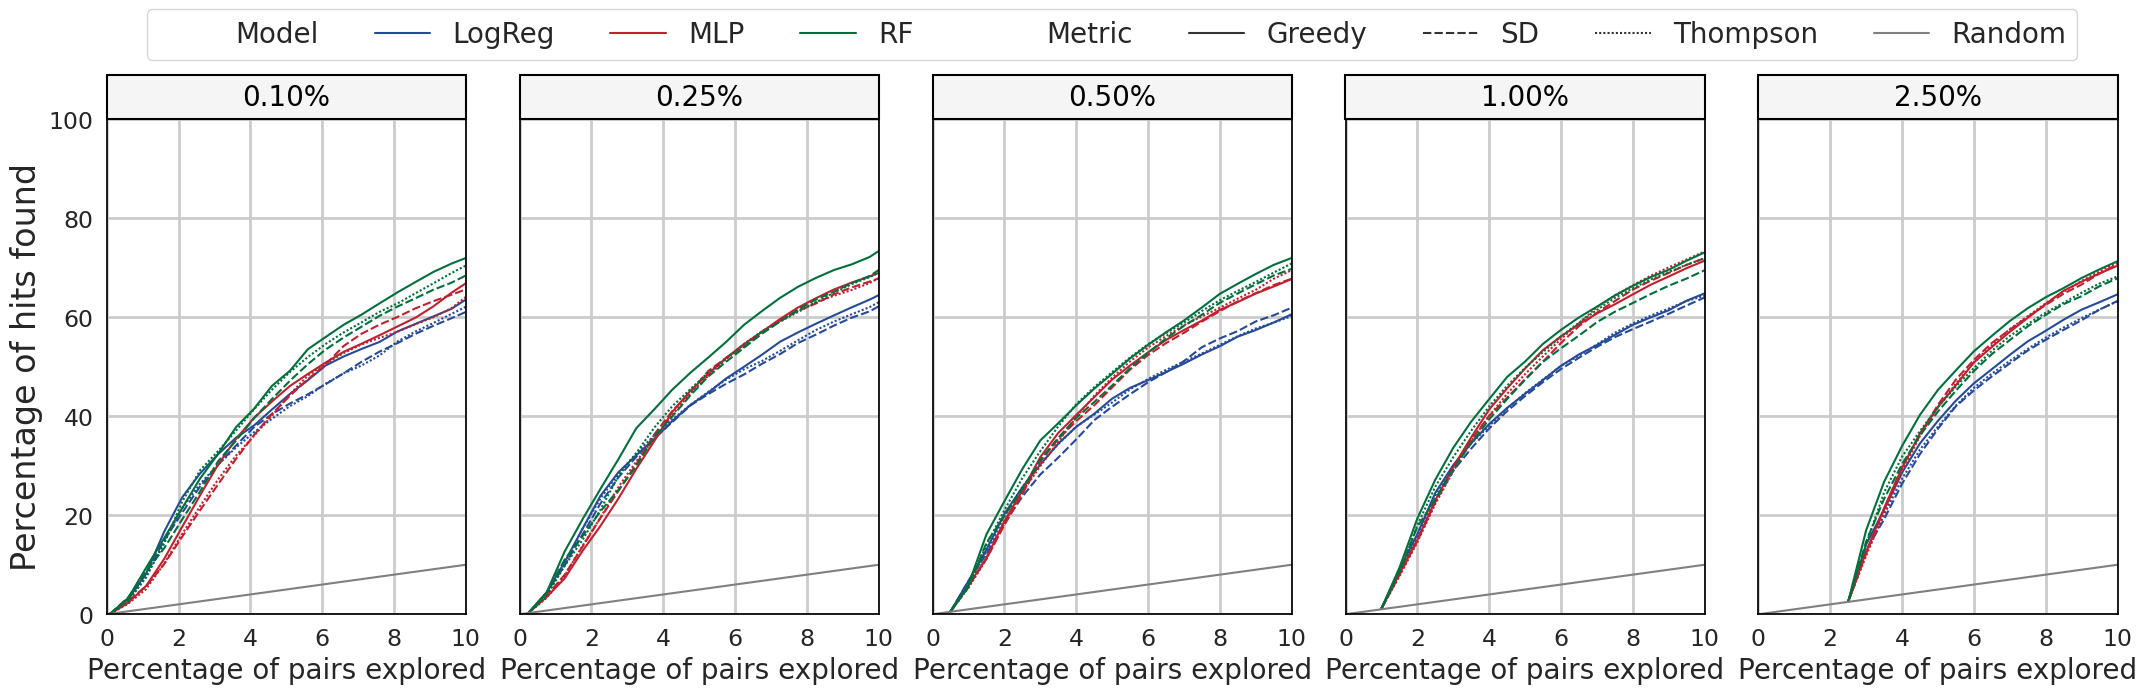

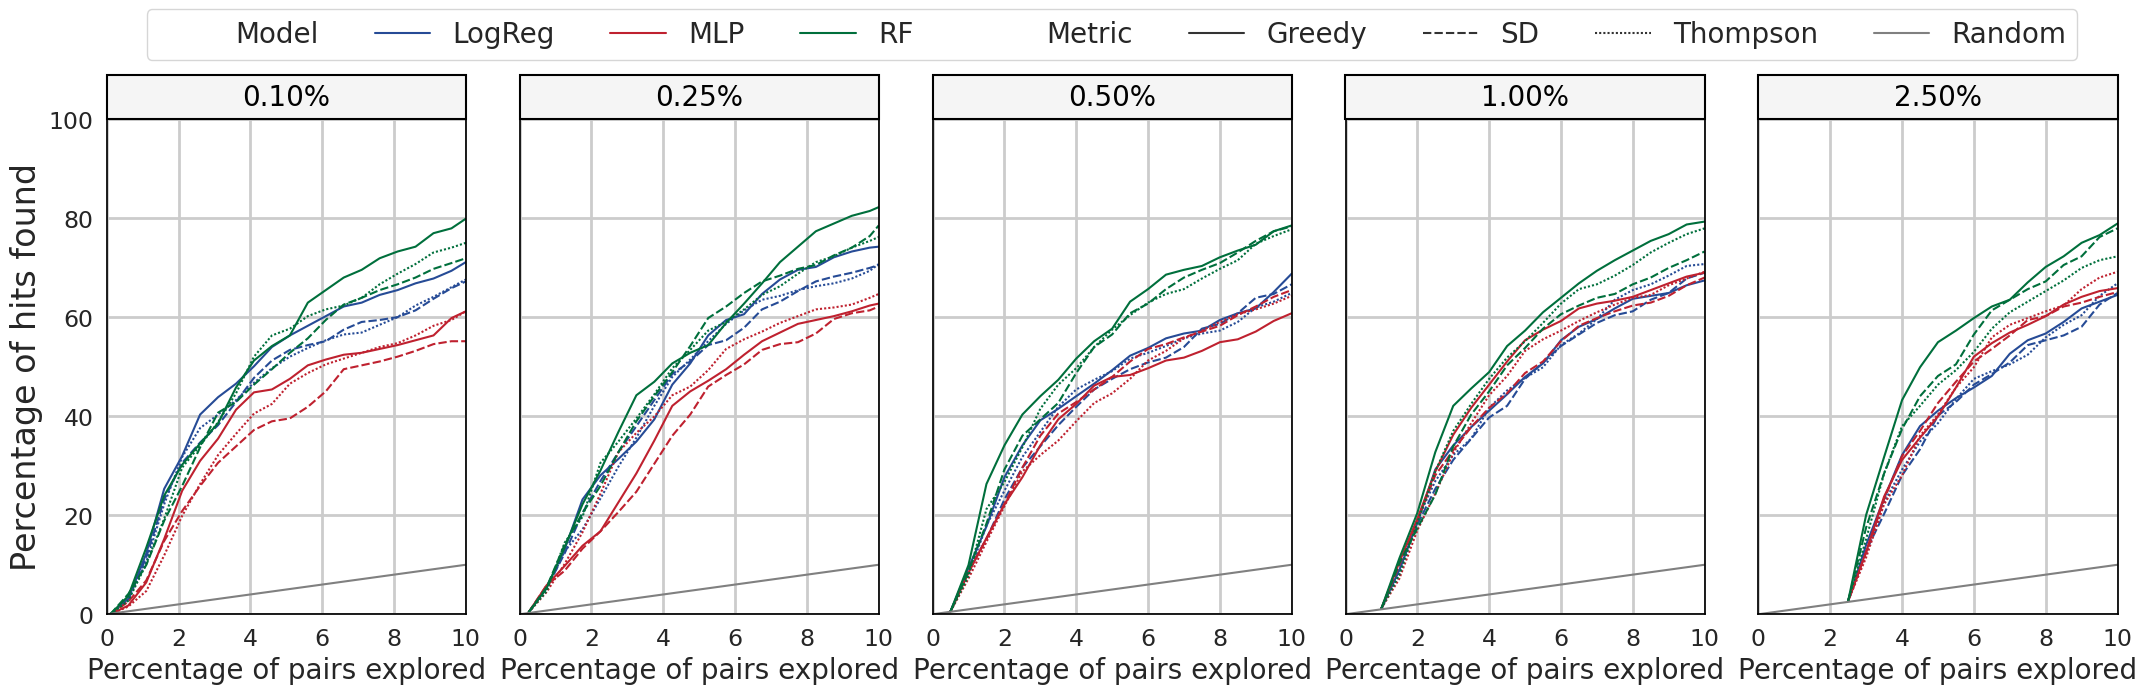

In [29]:
handles = get_handles(df_pairs, df_results, q, q_polar)
for q in [0.6, 0.7]:
    q_polar =0.25
    plot_init_batches(df_pairs, df_results, q, q_polar)

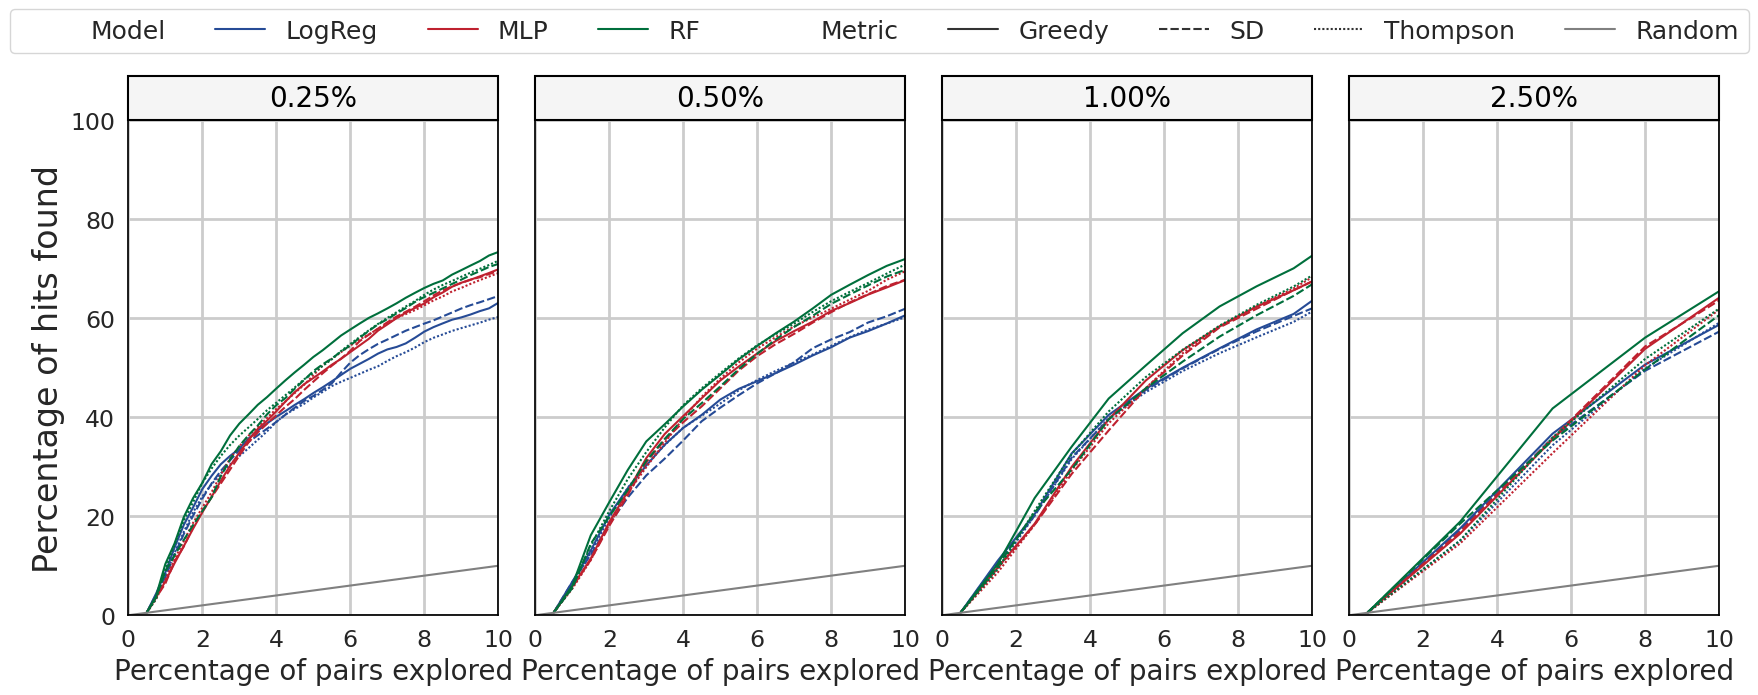

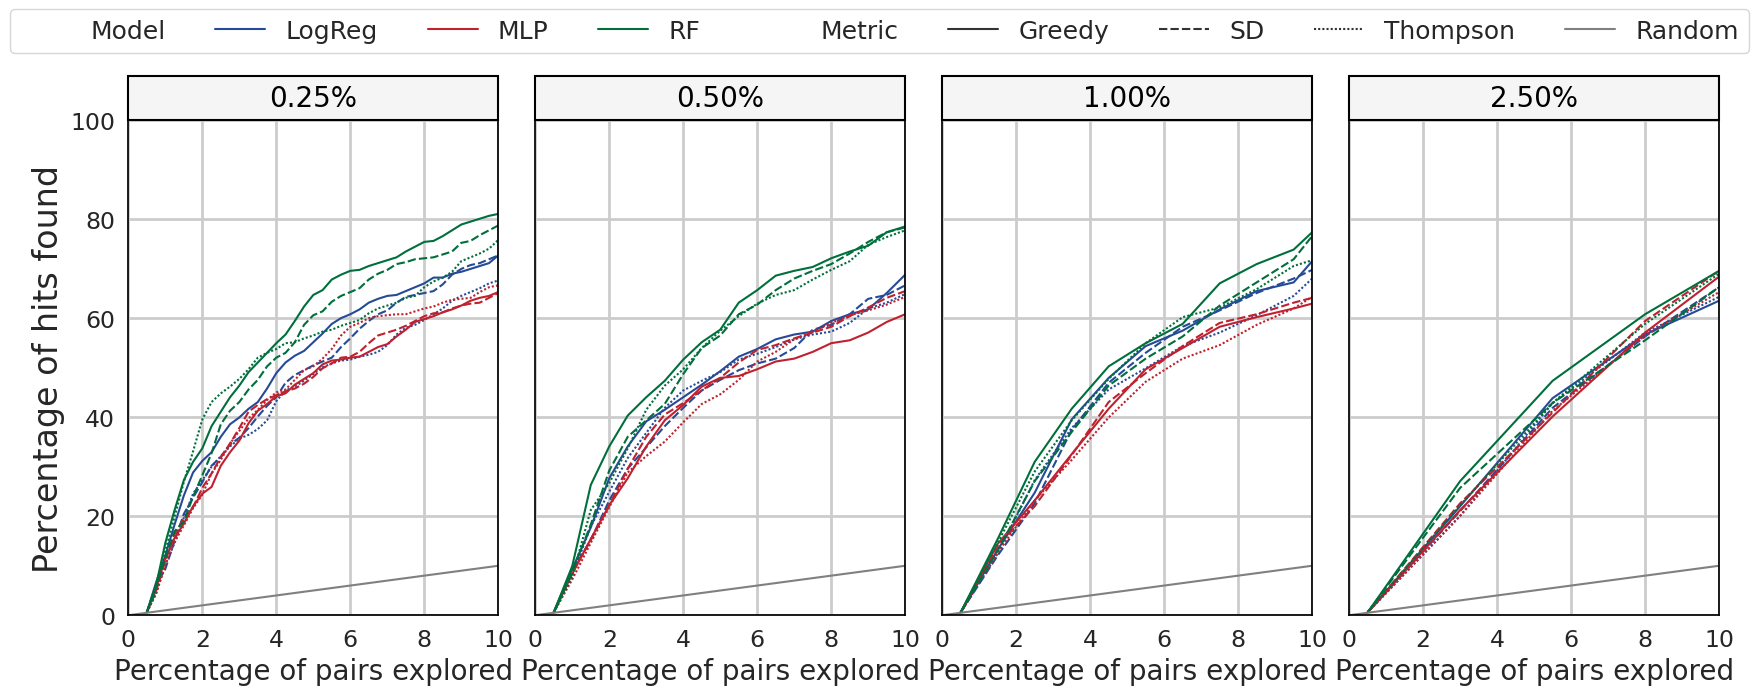

In [30]:
handles = get_handles(df_pairs, df_results, q, q_polar)
for q in [0.6, 0.7]:
    q_polar =0.25
    plot_explor_batches(df_pairs, df_results, q, q_polar)

In [31]:
q = 0.6
q_polar = 0.25

In [32]:
cond_greedy = (df_results['metric']=='greedy')&(df_results['model']=='rf')&(df_results['init_batch']==0.005)&(df_results['batch_size']==0.005)&(df_results['seed']==1)&(df_results['IFP']>=q)&(df_results['IFP_polar']>=q_polar)
cond_tompson = (df_results['metric']=='tompson')&(df_results['model']=='rf')&(df_results['init_batch']==0.005)&(df_results['batch_size']==0.005)&(df_results['seed']==1)&(df_results['IFP']>=q)&(df_results['IFP_polar']>=q_polar)
cond_sd = (df_results['metric']=='sd_deviation')&(df_results['model']=='rf')&(df_results['init_batch']==0.005)&(df_results['batch_size']==0.005)&(df_results['seed']==1)&(df_results['IFP']>=q)&(df_results['IFP_polar']>=q_polar)
df_greedy = df_results[cond_greedy][['name_1','name_2','reaction']]
df_tompson = df_results[cond_tompson][['name_1','name_2','reaction']]
df_sd = df_results[cond_sd][['name_1','name_2','reaction']]

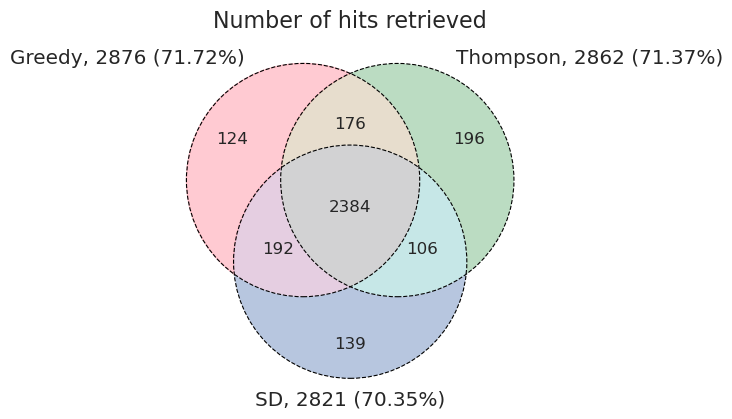

In [33]:
plot_venn(df_pairs, df_greedy, df_tompson, df_sd, q, q_polar)

### 1M CACHE4 no reaction descriptors

In [14]:
df_pairs = pd.read_csv('/projects/ML-SpaceDock/data/CBLB/1M_CBLB_pairs.tsv', delimiter='\t')
df_results = read_results(df_pairs, '/projects/ML-SpaceDock/CACHE4_1M/results/no_reaction_descriptors/')
df_times = read_times('/projects/ML-SpaceDock/CACHE4_1M/results/no_reaction_descriptors/')

In [15]:
q = 0.6 
q_polar = 0.25

In [16]:
df_counters = count(df_pairs, df_results[df_results['batch_size'] == 0.005], q, q_polar)
df = pd.DataFrame()
df.index = df_counters.groupby(by=['init_batch','model','metric']).apply(lambda group: get_value(group, 5)).index
for p in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    df[f'{p}%'] = df_counters.groupby(by=['init_batch','model','metric']).apply(lambda group: get_value(group, p))
df.style.highlight_max(color = 'yellow', axis = 0)

In [17]:
df_counters = count(df_pairs, df_results[df_results['init_batch'] == 0.005], q, q_polar)
df = pd.DataFrame()
df.index = df_counters.groupby(by=['batch_size','model','metric']).apply(lambda group: get_value(group, 5)).index
for p in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    df[f'{p}%'] = df_counters.groupby(by=['batch_size','model','metric']).apply(lambda group: get_value(group, p))
df.style.highlight_max(color = 'yellow', axis = 0)

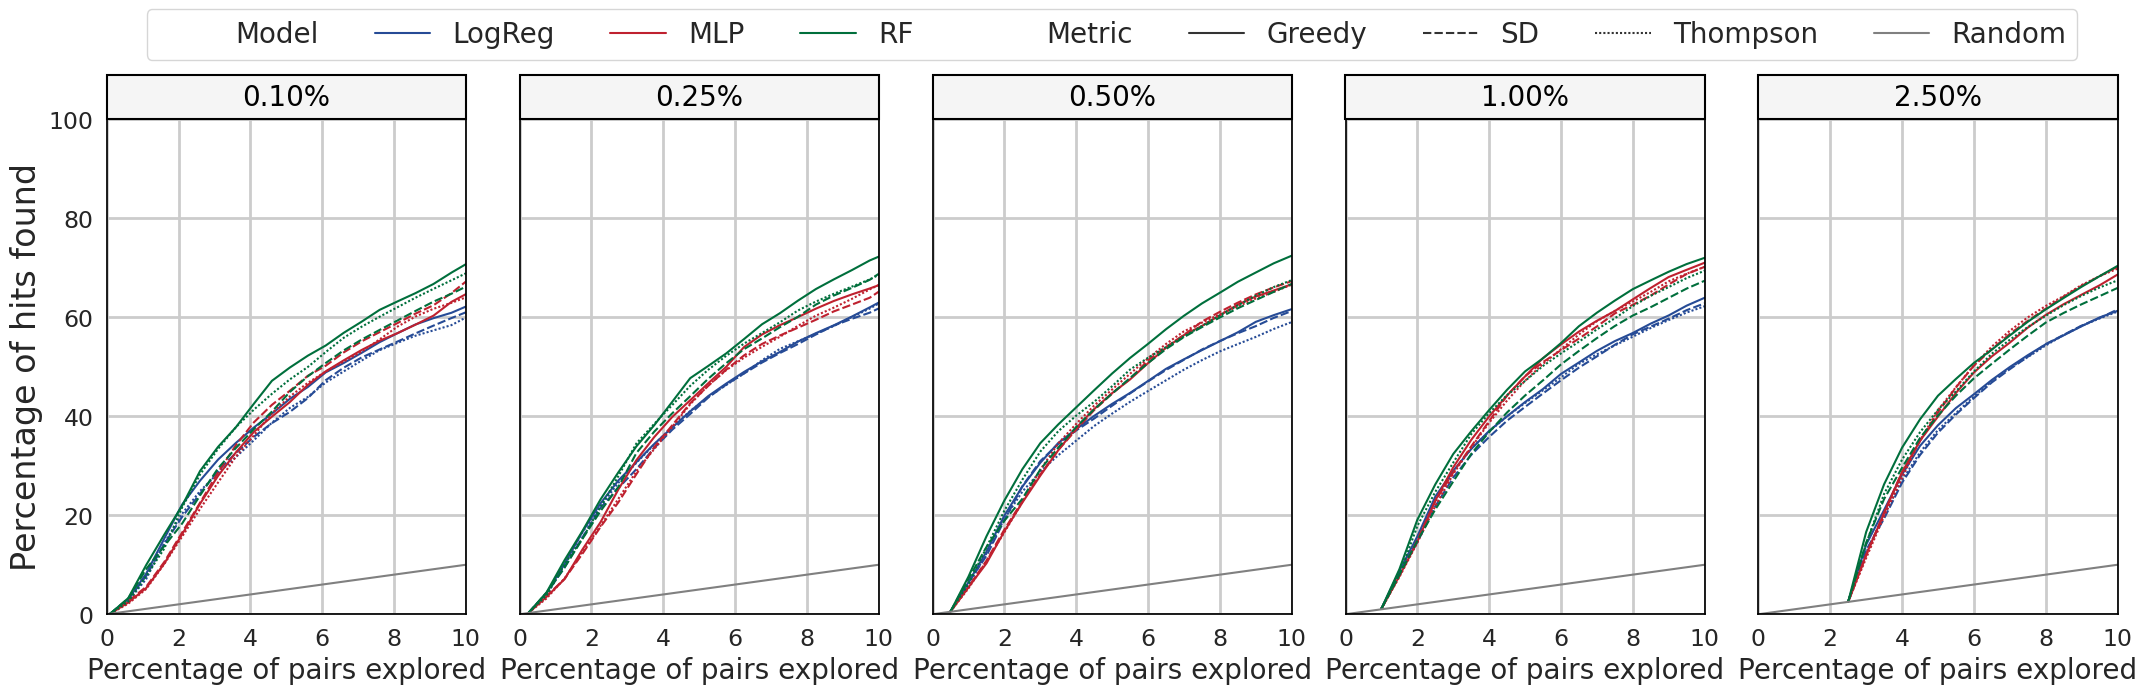

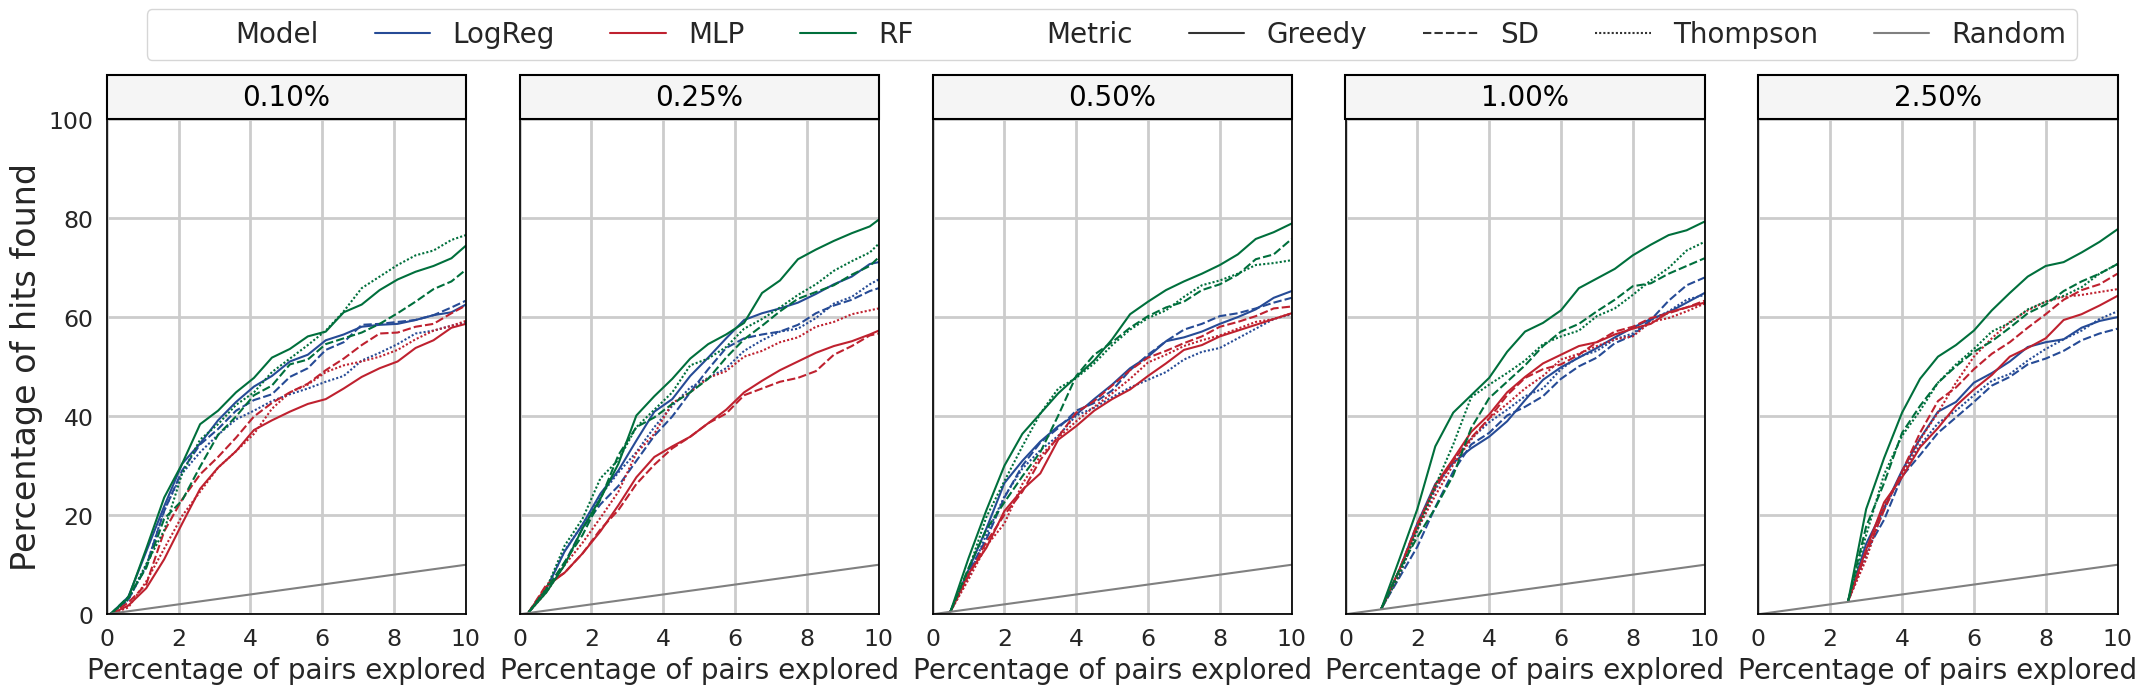

In [18]:
handles = get_handles(df_pairs, df_results, q, q_polar)
for q in [0.6, 0.7]:
    q_polar =0.25
    plot_init_batches(df_pairs, df_results, q, q_polar)

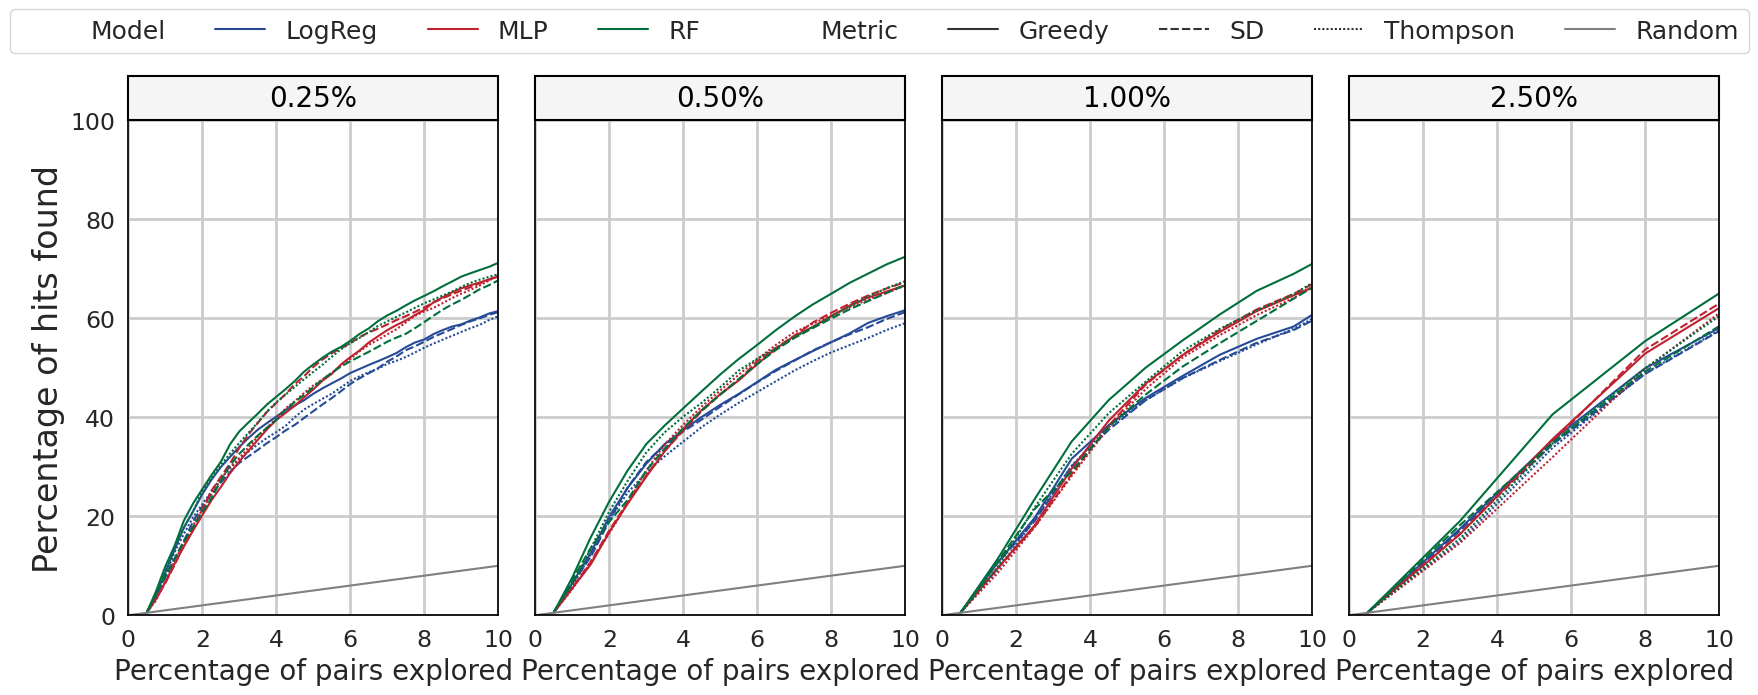

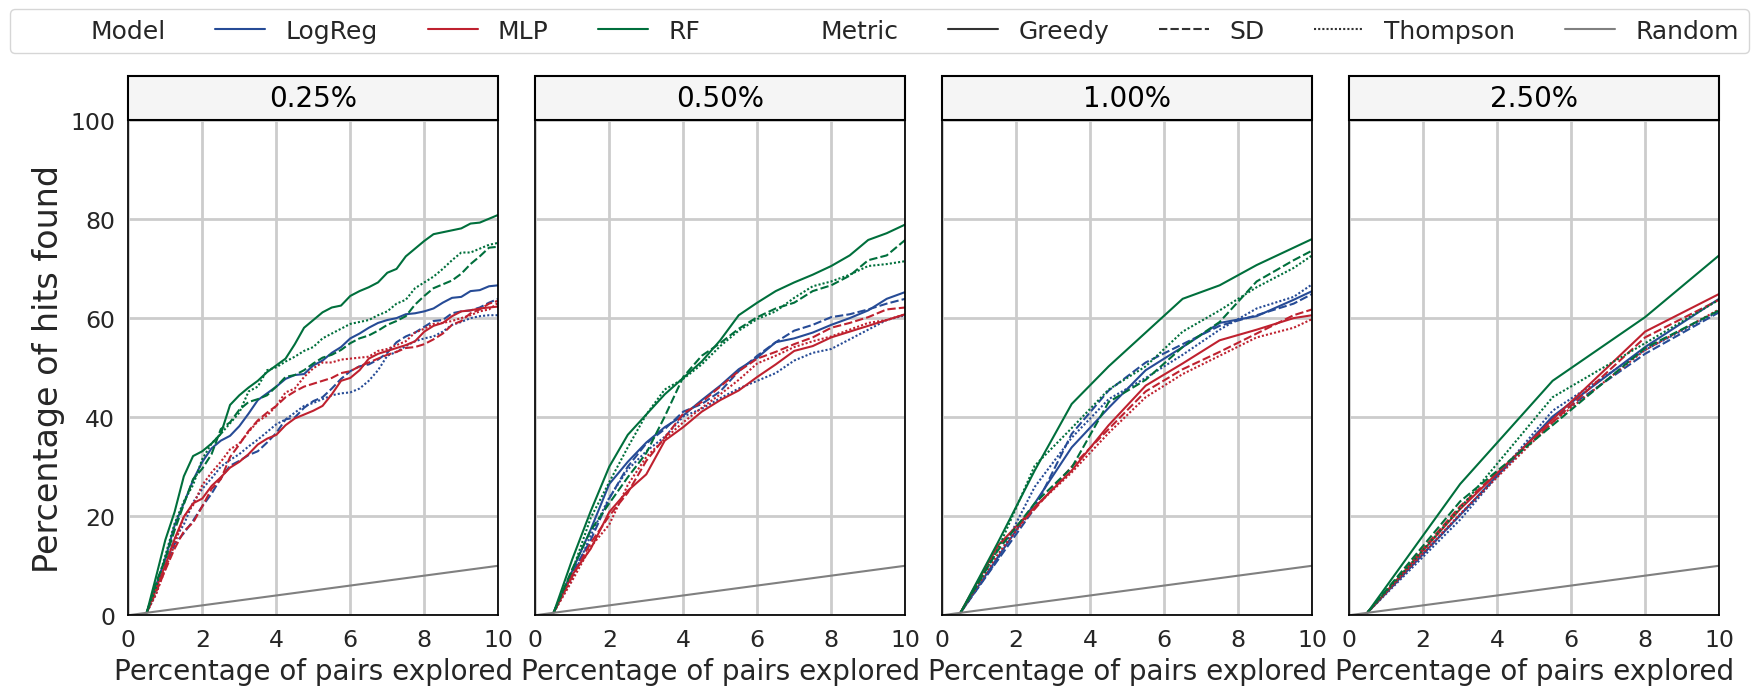

In [19]:
handles = get_handles(df_pairs, df_results, q, q_polar)
for q in [0.6, 0.7]:
    q_polar =0.25
    plot_explor_batches(df_pairs, df_results, q, q_polar)

## MLP Pytorch

In [15]:
df_pairs = pd.read_csv('/projects/ML-SpaceDock/data/DRD3/1M_DRD3_pairs.tsv', delimiter='\t')

In [16]:
df_results = pd.DataFrame()
for metric in ['greedy', 'thompson', 'sd_deviation']:
    for init_batch in [0.1, 0.25, 0.5, 1, 2.5]:
        explor_batch = 0.5
        dir_name = f'/projects/ML-SpaceDock/1M_gpu_experiments/DRD3_{metric}_{init_batch}_{explor_batch}_1/'
        for i in range(len(os.listdir(dir_name))-4):
            batch_idxs = np.load(f'{dir_name}{i}_batch_idxs.npy')
            df_ = df_pairs.iloc[batch_idxs].copy()
            df_['batch'] = i
            df_['metric'] = metric
            df_['model'] = 'mlp_pytorch'
            df_['init_batch'] = init_batch/100
            df_['batch_size'] = explor_batch/100
            df_['seed'] = 1
            
            df_results = pd.concat([df_results, df_,])
            
    for explor_batch in [0.25, 1, 2.5]:
        init_batch = 0.5
        dir_name = f'/projects/ML-SpaceDock/1M_gpu_experiments/DRD3_{metric}_{init_batch}_{explor_batch}_1/'
        for i in range(len(os.listdir(dir_name))-4):
            batch_idxs = np.load(f'{dir_name}{i}_batch_idxs.npy')
            df_ = df_pairs.iloc[batch_idxs].copy()
            df_['batch'] = i
            df_['metric'] = metric
            df_['model'] = 'mlp_pytorch'
            df_['init_batch'] = init_batch/100
            df_['batch_size'] = explor_batch/100
            df_['seed'] = 1
            
            df_results = pd.concat([df_results, df_,])

In [17]:
q = 0.6
q_polar = 0.5

In [18]:
df_counters = count(df_pairs, df_results[df_results['batch_size'] == 0.005], q, q_polar)
df = pd.DataFrame()
df.index = df_counters.groupby(by=['init_batch','model','metric']).apply(lambda group: get_value(group, 5)).index
for p in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    df[f'{p}%'] = df_counters.groupby(by=['init_batch','model','metric']).apply(lambda group: get_value(group, p))
df.style.highlight_max(color = 'yellow', axis = 0)

In [19]:
df_counters = count(df_pairs, df_results[df_results['init_batch'] == 0.005], q, q_polar)
df = pd.DataFrame()
df.index = df_counters.groupby(by=['batch_size','model','metric']).apply(lambda group: get_value(group, 5)).index
for p in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    df[f'{p}%'] = df_counters.groupby(by=['batch_size','model','metric']).apply(lambda group: get_value(group, p))
df.style.highlight_max(color = 'yellow', axis = 0)

In [22]:
df_pairs = pd.read_csv('/projects/ML-SpaceDock/data/CBLB/1M_CBLB_pairs.tsv', delimiter='\t')

In [23]:
df_results = pd.DataFrame()
for metric in ['greedy', 'thompson', 'sd_deviation']:
    for init_batch in [0.1, 0.25, 0.5, 1, 2.5]:
        explor_batch = 0.5
        dir_name = f'/projects/ML-SpaceDock/1M_gpu_experiments/CBLB_{metric}_{init_batch}_{explor_batch}_1/'
        for i in range(len(os.listdir(dir_name))-4):
            batch_idxs = np.load(f'{dir_name}{i}_batch_idxs.npy')
            df_ = df_pairs.iloc[batch_idxs].copy()
            df_['batch'] = i
            df_['metric'] = metric
            df_['model'] = 'mlp_pytorch'
            df_['init_batch'] = init_batch/100
            df_['batch_size'] = explor_batch/100
            df_['seed'] = 1
            
            df_results = pd.concat([df_results, df_,])
            
    for explor_batch in [0.25, 1, 2.5]:
        init_batch = 0.5
        dir_name = f'/projects/ML-SpaceDock/1M_gpu_experiments/CBLB_{metric}_{init_batch}_{explor_batch}_1/'
        for i in range(len(os.listdir(dir_name))-4):
            batch_idxs = np.load(f'{dir_name}{i}_batch_idxs.npy')
            df_ = df_pairs.iloc[batch_idxs].copy()
            df_['batch'] = i
            df_['metric'] = metric
            df_['model'] = 'mlp_pytorch'
            df_['init_batch'] = init_batch/100
            df_['batch_size'] = explor_batch/100
            df_['seed'] = 1
            
            df_results = pd.concat([df_results, df_,])

In [24]:
q = 0.6
q_polar = 0.25

In [25]:
df_counters = count(df_pairs, df_results[df_results['batch_size'] == 0.005], q, q_polar)
df = pd.DataFrame()
df.index = df_counters.groupby(by=['init_batch','model','metric']).apply(lambda group: get_value(group, 5)).index
for p in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    df[f'{p}%'] = df_counters.groupby(by=['init_batch','model','metric']).apply(lambda group: get_value(group, p))
df.style.highlight_max(color = 'yellow', axis = 0)

In [26]:
df_counters = count(df_pairs, df_results[df_results['init_batch'] == 0.005], q, q_polar)
df = pd.DataFrame()
df.index = df_counters.groupby(by=['batch_size','model','metric']).apply(lambda group: get_value(group, 5)).index
for p in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    df[f'{p}%'] = df_counters.groupby(by=['batch_size','model','metric']).apply(lambda group: get_value(group, p))
df.style.highlight_max(color = 'yellow', axis = 0)